<a href="https://colab.research.google.com/github/VasundharaAgarwal/GANFingerprinting/blob/main/Fingerprint_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import torch
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
import torchvision.utils as vutils

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
import sys
sys.path.append('/content/gdrive/My Drive/')

In [5]:
import model_architectures as ma

In [17]:
manualSeed = 500

torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)

fixed_noise = torch.randn(512,  ma.nz, 1, 1)



In [96]:
netG1 = ma.Generator1(0)
model_dict1 = torch.load('/content/gdrive/My Drive/GANS/GAN_1', map_location=torch.device('cpu'))
netG1.load_state_dict(model_dict1['G_state_dict'])


<All keys matched successfully>

In [19]:
netG2 = ma.Generator2(0)
model_dict2 = torch.load('/content/gdrive/My Drive/GANS/GAN_2', map_location=torch.device('cpu'))
netG2.load_state_dict(model_dict2['G_state_dict'])


<All keys matched successfully>

In [20]:
netG3 = ma.Generator3(0)
model_dict3 = torch.load('/content/gdrive/My Drive/GANS/GAN_3', map_location=torch.device('cpu'))
netG3.load_state_dict(model_dict3['G_state_dict'])


<All keys matched successfully>

In [21]:
fake1_finger = netG1(fixed_noise).detach().numpy().reshape(512,28,28)
fake2_finger = netG2(fixed_noise).detach().numpy().reshape(512,28,28)
fake3_finger = netG3(fixed_noise).detach().numpy().reshape(512,28,28)

In [140]:
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True, transform=torchvision.transforms.ToTensor()), batch_size=1512)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [161]:
real_img = images.numpy().reshape(1512,28,28)
real_finger = real_img[:512]
real_test = real_img[512:]


((512, 28, 28), (1000, 28, 28))

In [162]:
np.save('/content/gdrive/My Drive/GANS/Images_Fingerprints/GAN_1_images', fake1_finger)
np.save('/content/gdrive/My Drive/GANS/Images_Fingerprints/GAN_2_images', fake2_finger)
np.save('/content/gdrive/My Drive/GANS/Images_Fingerprints/GAN_3_images', fake3_finger)
np.save('/content/gdrive/My Drive/GANS/Images_Fingerprints/Real_images', real_finger)

In [164]:
def compute_fingerprint(gan_num, denoising_method="median blur"):
  fig, ax = plt.subplots(1,4, figsize = (20,15))
  N = [2,8,64,512]
  file_name_load = "GAN_{:d}_images.npy".format(gan_num) if gan_num > 0 else "Real_images.npy"
  images_finger = np.load('/content/gdrive/My Drive/GANS/Images_Fingerprints/'+file_name_load)
  for ind, num in enumerate(N,0):
    residue_sum = np.zeros((28,28))
    for i in range(num):
      img = images_finger[i]
      dst = []
      if (denoising_method == "median blur"):
        dst = cv2.medianBlur(img, 3)
      elif (denoising_method == "gaussian blur"):
        dst = cv2.GaussianBlur(img, ksize=(3,3), sigmaX=1)
      residue = img - dst
      residue_sum += residue
    residue_sum /= num
    if(num == 512):
      file_name_save = "print_GAN_{:d}".format(gan_num) if gan_num > 0 else "print_real"
      np.save('/content/gdrive/My Drive/GANS/Fingerprints/'+file_name_save+'_{}'.format(denoising_method.replace(" ","_")), residue_sum)
    ax[ind].imshow(residue_sum)
    ax[ind].set_title('N = {:d}'.format(num))


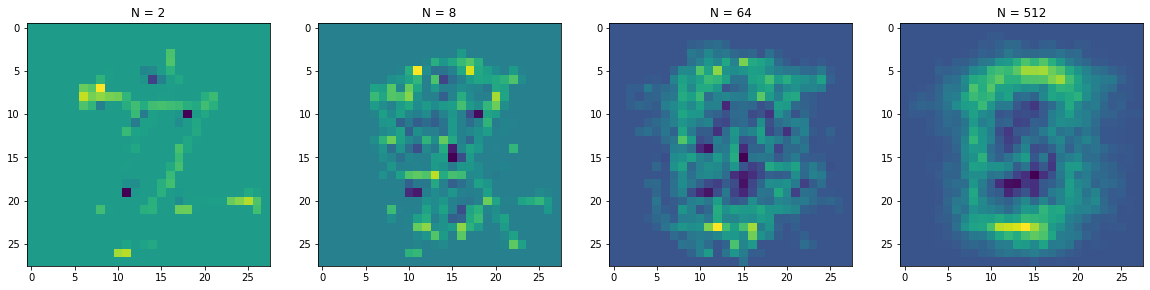

In [165]:
compute_fingerprint(0, "median blur")

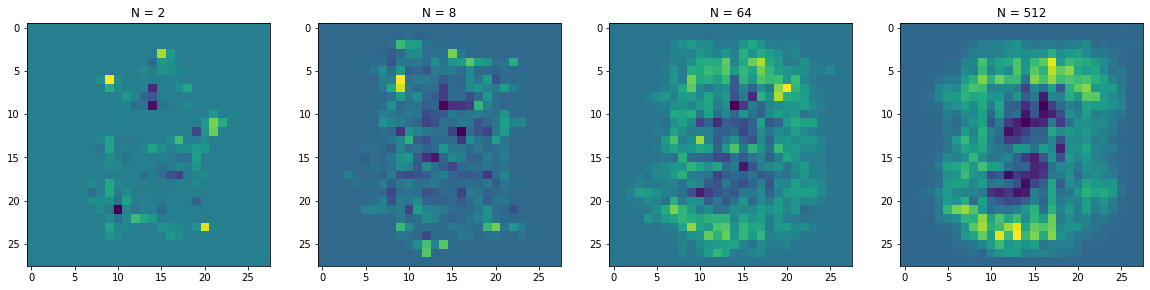

In [86]:
compute_fingerprint(1, "median blur")

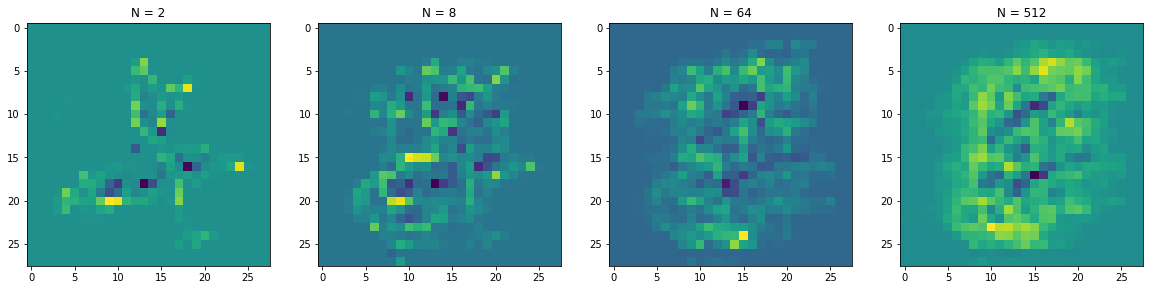

In [87]:
compute_fingerprint(2, "median blur")

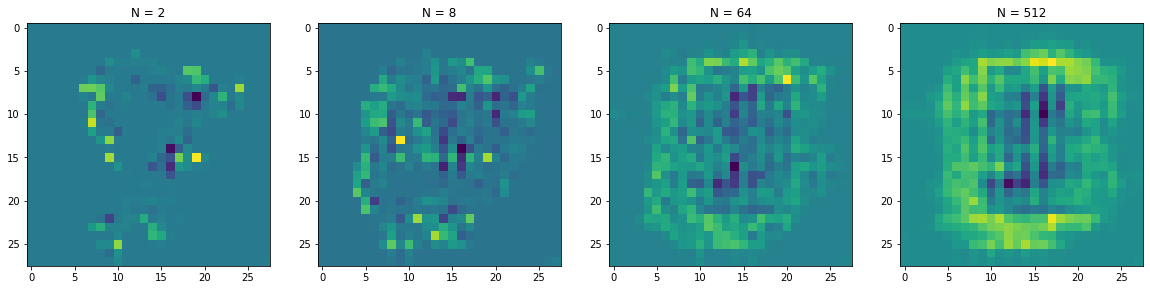

In [88]:
compute_fingerprint(3, "median blur")

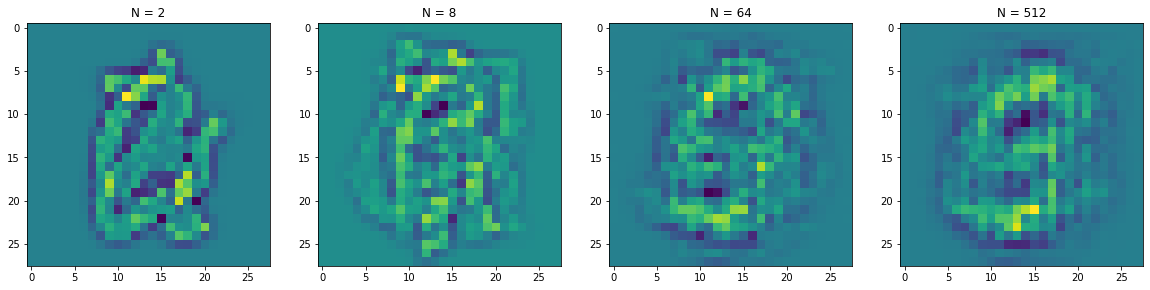

In [53]:
compute_fingerprint(1, "gaussian blur")

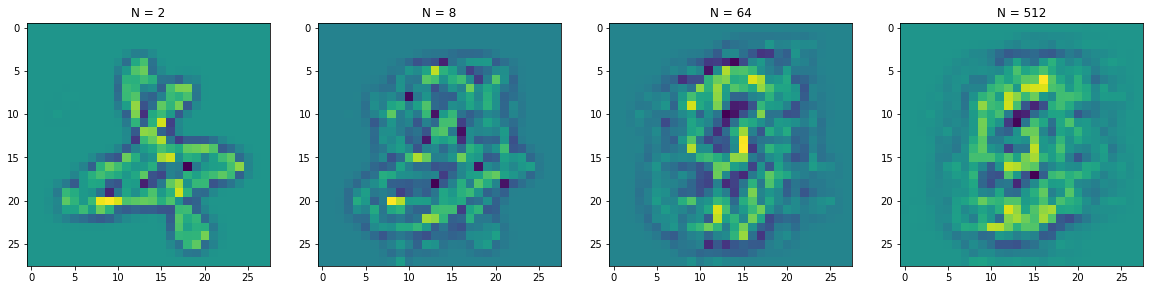

In [54]:
compute_fingerprint(2, "gaussian blur")

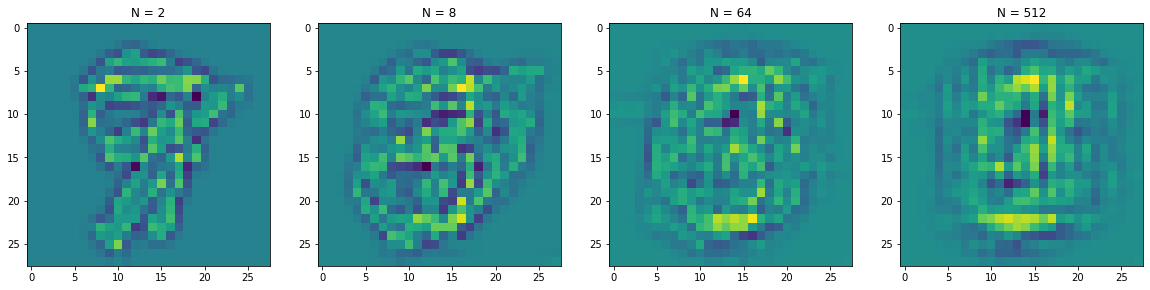

In [55]:
compute_fingerprint(3, "gaussian blur")

In [149]:
images, labels = next(iter(test_loader))

In [166]:
fixed_noise = torch.randn(1000,  ma.nz, 1, 1)
fake1_test = netG1(fixed_noise).detach().numpy().reshape(1000,28,28)
fake2_test = netG2(fixed_noise).detach().numpy().reshape(1000,28,28)
fake3_test = netG3(fixed_noise).detach().numpy().reshape(1000,28,28)


In [185]:
np.save('/content/gdrive/My Drive/GANS/Images_Testing/GAN_1_images', fake1_test)
np.save('/content/gdrive/My Drive/GANS/Images_Testing/GAN_2_images', fake2_test)
np.save('/content/gdrive/My Drive/GANS/Images_Testing/GAN_3_images', fake3_test)
np.save('/content/gdrive/My Drive/GANS/Images_Testing/Real_images', real_test)

In [272]:
def load_fingerprints(denoising_method):
  fingerprint_real = np.load('/content/gdrive/My Drive/GANS/Fingerprints/print_real_{}.npy'.format(denoising_method.replace(" ", "_")))
  fingerprint1 = np.load('/content/gdrive/My Drive/GANS/Fingerprints/print_GAN_1_{}.npy'.format(denoising_method.replace(" ", "_")))
  fingerprint2 = np.load('/content/gdrive/My Drive/GANS/Fingerprints/print_GAN_2_{}.npy'.format(denoising_method.replace(" ", "_")))
  fingerprint3 = np.load('/content/gdrive/My Drive/GANS/Fingerprints/print_GAN_3_{}.npy'.format(denoising_method.replace(" ", "_")))
  return (fingerprint_real.flatten(), fingerprint1.flatten(), fingerprint2.flatten(), fingerprint3.flatten())

In [273]:
def compute_corr_coeff(gan_num, denoising_method="median blur"):
  coefs_real = []
  coefs_gan_1 = []
  coefs_gan_2 = []
  coefs_gan_3 = []
  file_name_load = "GAN_{:d}_images.npy".format(gan_num) if gan_num > 0 else "Real_images.npy"
  fake_test = np.load('/content/gdrive/My Drive/GANS/Images_Testing/'+file_name_load)
  fingerprint_real, fingerprint1, fingerprint2, fingerprint3 = load_fingerprints(denoising_method)
  for i in range(1000):
    img = fake_test[i]
    if (denoising_method == "median blur"):
      dst = cv2.medianBlur(img, 3)
    elif (denoising_method == "gaussian blur"):
      dst = cv2.GaussianBlur(img, (3,3), 1)
    residual = (img - dst).flatten()
    coef_real = np.corrcoef(fingerprint_real, residual)[0][1]
    coef1 = np.corrcoef(fingerprint1, residual)[0][1]
    coef2 = np.corrcoef(fingerprint2, residual)[0][1]
    coef3 = np.corrcoef(fingerprint3, residual)[0][1]
    coefs_real.append(coef_real)
    coefs_gan_1.append(coef1)
    coefs_gan_2.append(coef2)
    coefs_gan_3.append(coef3)
  
  return (coefs_real, coefs_gan_1, coefs_gan_2, coefs_gan_3)
  



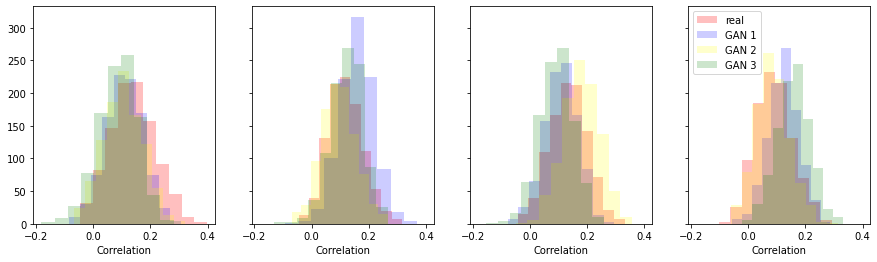

In [274]:
fig, ax = plt.subplots(1,4,figsize=(15,4), sharex=True, sharey=True)

for i in range(4):
  coefs_real, coefs_gan_1, coefs_gan_2, coefs_gan_3 = compute_corr_coeff(i, "median blur")
  ax[i].hist(coefs_real, color='red', alpha= 0.25, label="real")
  ax[i].hist(coefs_gan_1, color='blue', alpha = 0.2, label="GAN 1")
  ax[i].hist(coefs_gan_2, color='yellow', alpha = 0.2, label="GAN 2")
  ax[i].hist(coefs_gan_3, color='green', alpha = 0.2, label="GAN 3")
  ax[i].set_xlabel('Correlation')
plt.legend()
plt.show()


In [232]:
def get_accuracy(gan_num, denoising_method="median blur"):
  total = 0
  file_name_load = "GAN_{:d}_images.npy".format(gan_num) if gan_num > 0 else "Real_images.npy"
  fake_test = np.load('/content/gdrive/My Drive/GANS/Images_Testing/'+file_name_load)
  for i in range(1000):
    
    img = fake_test[i]
    if (denoising_method == "median blur"):
      dst = cv2.medianBlur(img, 3)
    elif (denoising_method == "gaussian blur"):
      dst = cv2.GaussianBlur(img, (3,3), 1)
    residual = (img - dst).flatten()
    fingerprint_real, fingerprint1, fingerprint2, fingerprint3 = load_fingerprints(denoising_method)
    dist_real = np.linalg.norm(fingerprint_real - residual)
    dist_1 = np.linalg.norm(fingerprint1 - residual)
    dist_2 = np.linalg.norm(fingerprint2 - residual)
    dist_3 = np.linalg.norm(fingerprint3 -  residual)
    scores = [dist_real, dist_1, dist_2, dist_3]
    if(scores.index(min(scores)) == gan_num):
      total=total+1
  return (total/1000)


In [233]:
get_accuracy(0)

510